# Аренда самокатов 🛴

**Описание проекта:** За последние пару лет самокаты превратились из редкости в одно из самых популярных средств передвижения по городу. Сервисы аренды самокатов являются полноценным бизнесом. Как и любой другой бизнес, они стремятся увеличить выручку.

**Цель проекта:** Нам передали данные популярного сервиса аренды самокатов GoFast. Есть данные о некоторых пользователях из нескольких городов, а также об их поездках. Требуется проанализировать данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Ход исследования:**
- Подготовка данных: загрузка и изучение общей информации
- Предобработка данных: обработка пропущенных значений и дубликатов, корректировка типов данных
- Объединение датасетов
- Подсчет выручки
- Проверка гипотез

**Содержание**<a id='toc0_'></a>    
1. [Подготовка     ](#toc1_)    
1.1. [Установка библиотек     ](#toc1_1_)    
1.2. [Сервисные функции     ](#toc1_2_)    
2. [Данные     ](#toc2_)    
2.1. [Загрузка     ](#toc2_1_)    
2.2. [Генерация новых столбцов     ](#toc2_2_)    
2.3. [Проверка полных дубликатов     ](#toc2_3_)    
2.4. [Обработка неявных дубликатов     ](#toc2_4_)    
2.5. [Проверка пропущенных значений     ](#toc2_5_)    
2.6. [Промежуточный вывод ](#toc2_6_)    
3. [Исследовательский анализ данных (EDA)     ](#toc3_)    
3.1. [Города пользователей     ](#toc3_1_)    
3.2. [Тип подписки     ](#toc3_2_)    
3.3. [Возраст пользователей     ](#toc3_3_)    
3.4. [Расстояние за 1 поездку     ](#toc3_4_)    
3.5. [Продолжительность поездок](#toc3_5_)    
3.6. [Вывод по исследовательскому анализу данных     ](#toc3_6_)    
4. [Объединение данных     ](#toc4_)    
4.1. [Объединение     ](#toc4_1_)    
4.2. [Визуализация различий     ](#toc4_2_)    
4.3. [Вывод по объединению данных     ](#toc4_3_)    
5. [Подсчет выручки     ](#toc5_)    
5.1. [Вывод ](#toc5_1_)    
6. [Проверка гипотез     ](#toc6_)    
6.1. [Продолжительность поездок     ](#toc6_1_)    
6.2. [Среднее расстояние поездки     ](#toc6_2_)    
6.3. [Сравнение помесячной выручки от пользователей с подпиской и без     ](#toc6_3_)    
6.4. [Ответ на вопрос     ](#toc6_4_)    
7. [Общий вывод ](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка      [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Установка библиотек      [&#8593;](#toc0_)

In [1]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else:
    pass
    %pip install --upgrade numpy -q
    
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade matplotlib -q
%pip install --upgrade seaborn -q
%pip install --upgrade bottleneck -q
%pip install --upgrade pandas -q
%pip install --upgrade scipy -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats as st

from prettytable import PrettyTable
from termcolor import colored

### 1.2. <a id='toc1_2_'></a>Сервисные функции      [&#8593;](#toc0_)

In [3]:
def print_table_about_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [4]:
def draw_plots_about_column(df: pd.DataFrame, column: str, column_description:  str, bins: int = 20) -> None:
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    sns.violinplot(df, y=column, ax=ax1)
    ax1.set_ylabel(column_description)
    ax1.grid()
    
    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    
    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')
    
    ax4.set_visible(False)
    
    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

## 2. <a id='toc2_'></a>Данные      [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка      [&#8593;](#toc0_)

In [5]:
# dataset is not presented due to copyright
users = pd.read_csv(path)

In [6]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


**Описание данных**

|Название|Описание|
|:--:|--|
|`user_id`|уникальный идентификатор пользователя|
|`name`|имя пользователя|
|`age`|возраст|
|`city`|город|
|`subscription_type`|тип подписки (free, ultra)|

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [8]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


---

In [9]:
# dataset is not presented due to copyright
rides = pd.read_csv(path, parse_dates=['date'])

In [10]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


**Описание данных**

|Название|Описание|
|:--:|--|
|`user_id`|уникальный идентификатор пользователя|
|`distance`|расстояние, которое пользователь проехал в текущей сессии (в метрах)|
|`duration`|продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»|
|`date`|дата совершения поездки|

In [11]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [12]:
rides.describe()

,user_id,distance,duration,date
count,18068.000000,18068.000000,18068.000000,18068
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00
std,434.734317,1116.831209,6.091051,NaN


---

In [13]:
# dataset is not presented due to copyright
subscriptions = pd.read_csv(path)

**Описание данных**

|Название|Описание|
|:--:|--|
|`subscription_type`|тип подписки|
|`minute_price`|стоимость одной минуты поездки по данной подписке|
|`start_ride_price`|стоимость начала поездки|
|`subscription_fee`|стоимость ежемесячного платежа|

In [14]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


In [15]:
subscriptions.describe()

,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


### 2.2. <a id='toc2_2_'></a>Генерация новых столбцов      [&#8593;](#toc0_)

In [16]:
rides['month'] = rides['date'].dt.month

In [17]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### 2.3. <a id='toc2_3_'></a>Проверка полных дубликатов      [&#8593;](#toc0_)

In [18]:
users.duplicated().sum()

31

In [19]:
users = users.drop_duplicates()

In [20]:
users.duplicated().sum()

0

---

In [21]:
rides.duplicated().sum()

0

---

In [22]:
subscriptions.duplicated().sum()

0

### 2.4. <a id='toc2_4_'></a>Обработка неявных дубликатов      [&#8593;](#toc0_)

In [23]:
sorted(users['name'].unique())

['Агата',
 'Аделина',
 'Адель',
 'Айдар',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алия',
 'Алла',
 'Альберт',
 'Альбина',
 'Алёна',
 'Амалия',
 'Амина',
 'Амир',
 'Анастасия',
 'Анатолий',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анна',
 'Антон',
 'Антонина',
 'Ариана',
 'Арина',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артур',
 'Артём',
 'Богдан',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Василий',
 'Василина',
 'Василиса',
 'Вера',
 'Вероника',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Виталина',
 'Влад',
 'Влада',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Вячеслав',
 'Галина',
 'Георгий',
 'Герман',
 'Глеб',
 'Гордей',
 'Григорий',
 'Давид',
 'Дамир',
 'Даниил',
 'Данил',
 'Данила',
 'Даниэль',
 'Дарина',
 'Дарья',
 'Демид',
 'Денис',
 'Диана',
 'Дмитрий',
 'Ева',
 'Евгений',
 'Евгения',
 'Егор',
 'Екатерина',
 'Елена',
 'Елизавета',
 'Елисей',
 'Есения',
 'Жанна',
 'Зарина',
 'Захар',
 'Злата',
 'Иван',
 'Игнат',

In [24]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [25]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

### 2.5. <a id='toc2_5_'></a>Проверка пропущенных значений      [&#8593;](#toc0_)

In [26]:
print_table_about_nans(users)

+-------------------+----------------------+
|      Feature      | Missing values count |
+-------------------+----------------------+
|      user_id      |      0 (0.00%)       |
|        name       |      0 (0.00%)       |
|        age        |      0 (0.00%)       |
|        city       |      0 (0.00%)       |
| subscription_type |      0 (0.00%)       |
+-------------------+----------------------+


In [27]:
print_table_about_nans(rides)

+----------+----------------------+
| Feature  | Missing values count |
+----------+----------------------+
| user_id  |      0 (0.00%)       |
| distance |      0 (0.00%)       |
| duration |      0 (0.00%)       |
|   date   |      0 (0.00%)       |
|  month   |      0 (0.00%)       |
+----------+----------------------+


In [28]:
print_table_about_nans(subscriptions)

+-------------------+----------------------+
|      Feature      | Missing values count |
+-------------------+----------------------+
| subscription_type |      0 (0.00%)       |
|    minute_price   |      0 (0.00%)       |
|  start_ride_price |      0 (0.00%)       |
|  subscription_fee |      0 (0.00%)       |
+-------------------+----------------------+


Как мы видим ни в одном датафрейме нет пропущенных значений.

### 2.6. <a id='toc2_6_'></a>Промежуточный вывод  [&#8593;](#toc0_)

Все датафреймы были обработаны:

- Изменены типы данных
- Удалены полные дубликаты
- Проверены неявные дубликаты
- Проверены пропуски

## 3. <a id='toc3_'></a>Исследовательский анализ данных (EDA)      [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Города пользователей      [&#8593;](#toc0_)

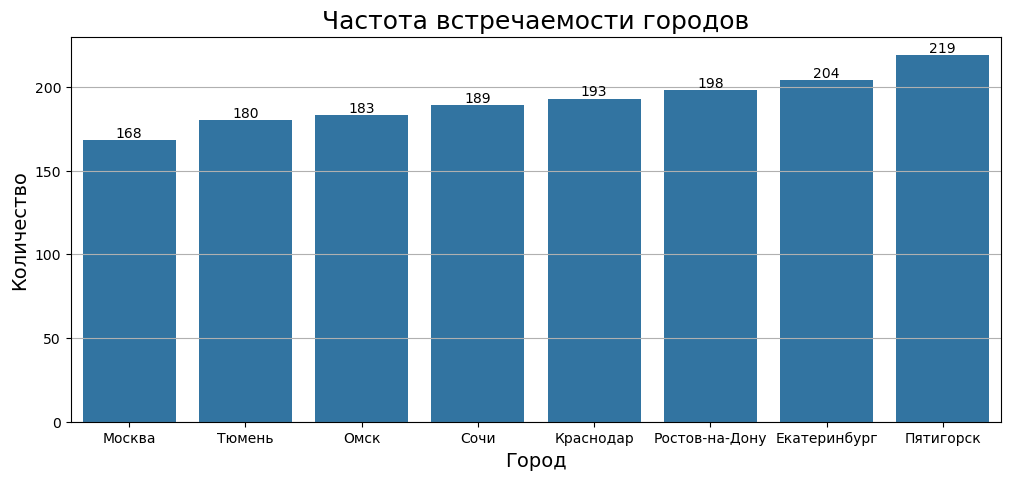

In [29]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=users,
                   x='city',
                   order=users['city']
                       .value_counts()
                       .sort_values()
                       .index)
plt.grid(axis='y')
ax.bar_label(ax.containers[0]);
ax.set_title('Частота встречаемости городов', fontsize=18)
ax.set_xlabel('Город', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
plt.show()

О каждом городе примерно одинаковое количество информации. Меньше всего информации о Москве (`168` пользователей), а больше всего о Пятигорске (`219` пользователей).

---

### 3.2. <a id='toc3_2_'></a>Тип подписки      [&#8593;](#toc0_)

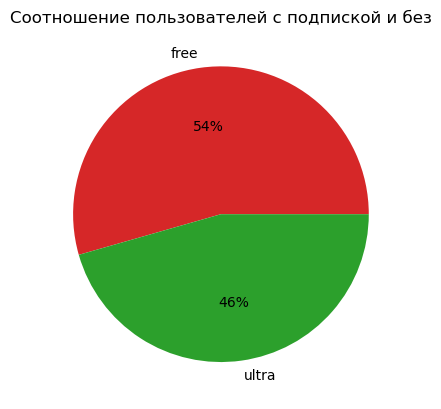

In [30]:
_table = users.value_counts('subscription_type')
data, labels = _table.values, _table.index
plt.pie(data, labels=labels, autopct='%.0f%%', colors=['tab:red', 'tab:green'])
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

По результатам графика можно сделать вывод, что пользователей без подписки на `8 п.п.` больше, чем с подпиской.

---

### 3.3. <a id='toc3_3_'></a>Возраст пользователей      [&#8593;](#toc0_)

In [31]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [32]:
_iqr = st.iqr(users['age'])
_q1, _q3 = np.quantile(users['age'], [0.25, 0.75])
print(f'[{_q1 - _iqr}; {_q3 + _iqr}]')

[16.0; 34.0]


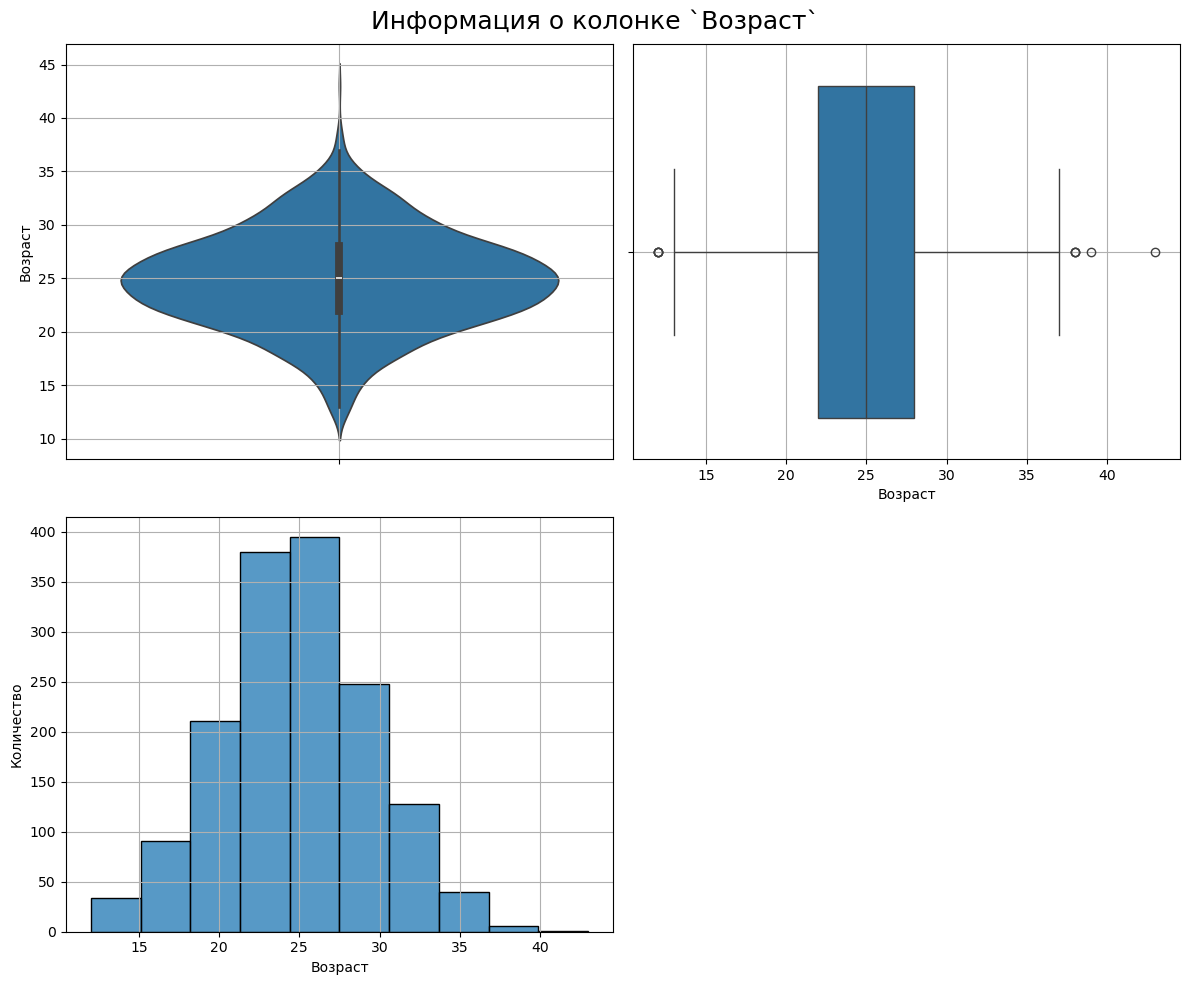

In [33]:
draw_plots_about_column(users, 'age', 'Возраст', 10)

Возраст пользователей имеет форму нормального распределения. Аномальных значений нет, а выбросы хоть и есть, но они являются вполне реальными значениями.

Минимальный возраст, о котором представлена информация - 12 лет, а максимальный - 43 года. Основная возрастная группа - от 16 до 34 лет, а средний возраст составляет 25 лет.

---

### 3.4. <a id='toc3_4_'></a>Расстояние за 1 поездку      [&#8593;](#toc0_)

In [34]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [35]:
_iqr = st.iqr(rides['distance'])
_q1, _q3 = np.quantile(rides['distance'], [0.25, 0.75])
print(f'[{_q1 - _iqr}; {_q3 + _iqr}]')

[1310.2299846149685; 5009.219110682625]


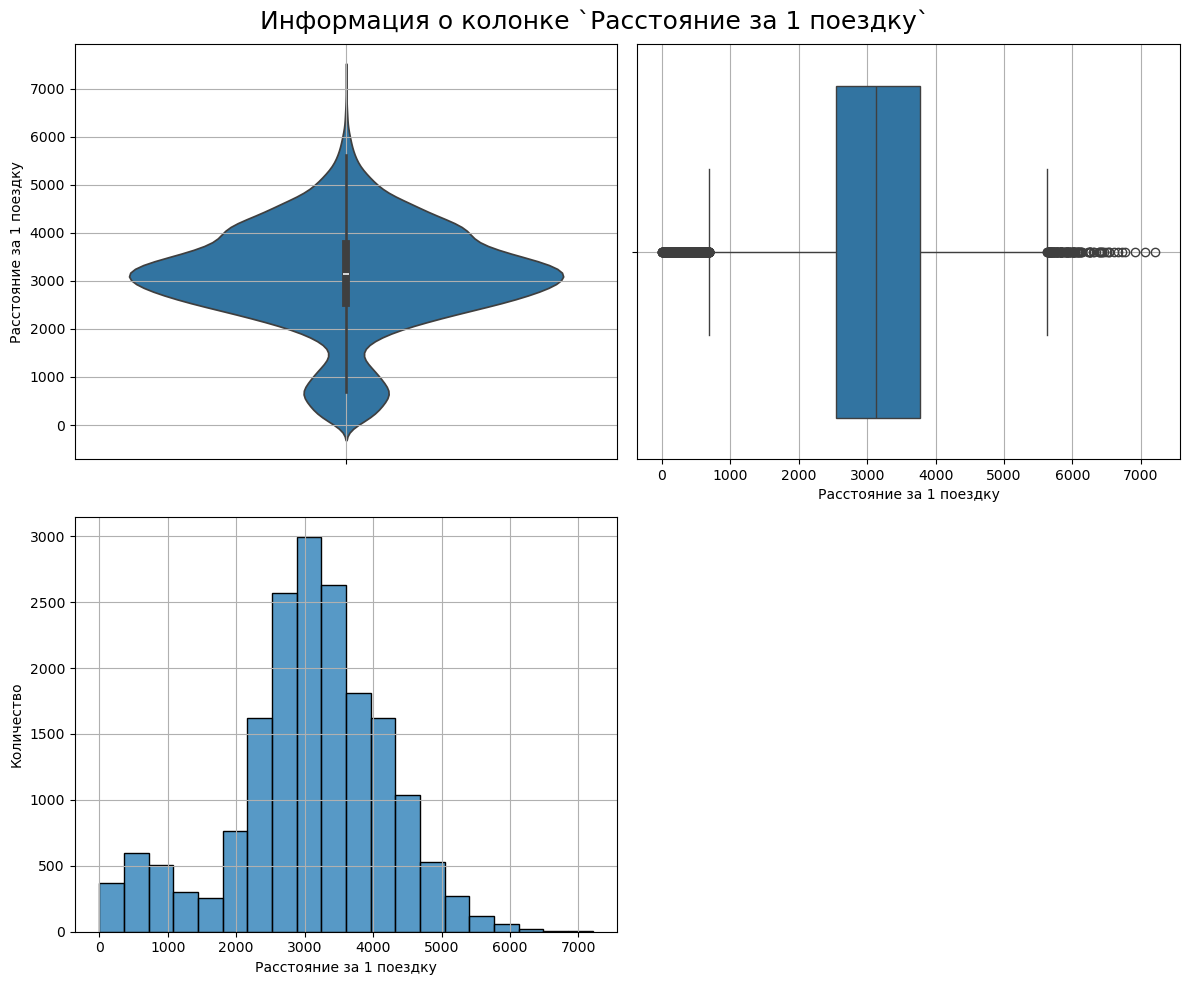

In [36]:
draw_plots_about_column(rides, 'distance', 'Расстояние за 1 поездку')

Расстояние за 1 поездку также имеет форму нормального распределения. Однако есть небольшой пик в поездках до `1000 м.`

Самая короткая поездка меньше метра, а самая длинная - более 7 км, целых `7211м`. Основная часть поездок находится в диапозоне от `1310` метров до `5009` метров. При этом средняя поездка составляет около `3км`.

### 3.5. <a id='toc3_5_'></a>Продолжительность поездок [&#8593;](#toc0_)

In [37]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [38]:
_iqr = st.iqr(rides['duration'])
_q1, _q3 = np.quantile(rides['duration'], [0.25, 0.75])
print(f'[{_q1 - _iqr}; {_q3 + _iqr}]')

[5.470325678700483; 29.85203719033973]


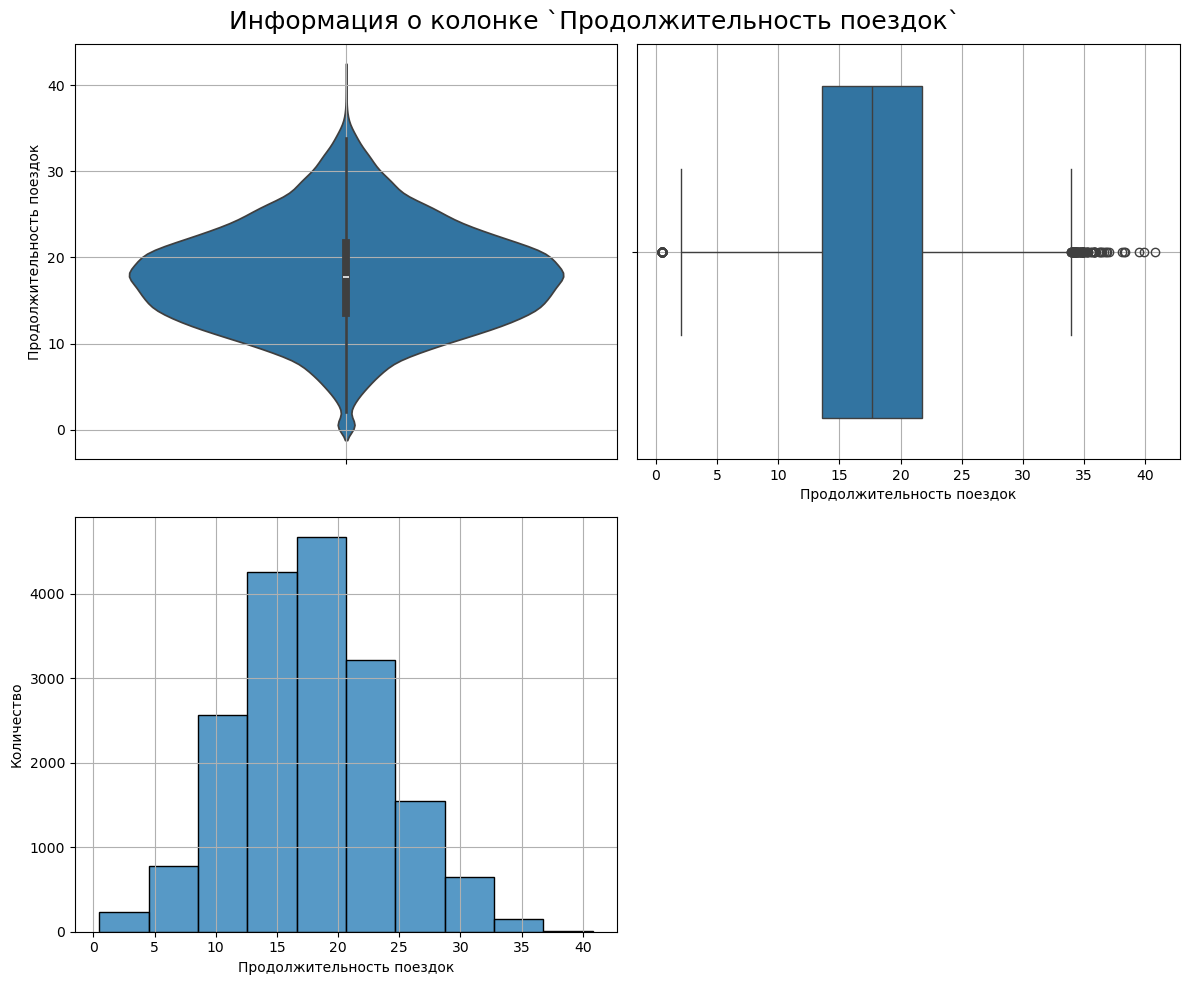

In [39]:
draw_plots_about_column(rides, 'duration', 'Продолжительность поездок', 10)

Продолжительность поездок также имеет форму нормального распределения. Самая короткая поездка длилась всего полминуты, а самая длинная почти `41` минуту. БОльшая часть поездок имеет длительность от `5.5` до `30` минут. При этом средняя длительность поездки - около `18` минут.

---

### 3.6. <a id='toc3_6_'></a>Вывод по исследовательскому анализу данных      [&#8593;](#toc0_)

**Города**  
О каждом городе примерно одинаковое количество информации. Меньше всего информации о Москве (`168` пользователей), а больше всего о Пятигорске (`219` пользователей).

**Наличие подписки**  
Можно сделать вывод, что пользователей без подписки на `8 п.п.` больше, чем с подпиской.

**Возраст**  
Возраст пользователей имеет форму нормального распределения. Аномальных значений нет, а выбросы хоть и есть, но они являются вполне реальными значениями.  
Минимальный возраст, о котором представлена информация - 12 лет, а максимальный - 43 года. Основная возрастная группа - от 16 до 34 лет, а средний возраст составляет 25 лет.


**Расстояние 1 поездки**  
Расстояние за 1 поездку также имеет форму нормального распределения. Однако есть небольшой пик в поездках до `1000 м.`  
Самая короткая поездка меньше метра, а самая длинная - более 7 км, целых `7211м`. Основная часть поездок находится в диапозоне от `1310` метров до `5009` метров. При этом средняя поездка составляет около `3км`.


**Продолжительность одной поездки**  
Продолжительность поездок также имеет форму нормального распределения. Самая короткая поездка длилась всего полминуты, а самая длинная почти `41` минуту. БОльшая часть поездок имеет длительность от `5.5` до `30` минут. При этом средняя длительность поездки - около `18` минут.

## 4. <a id='toc4_'></a>Объединение данных      [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Объединение      [&#8593;](#toc0_)

In [40]:
rides.shape

(18068, 5)

In [41]:
df = pd.merge(left=users, right=subscriptions, on='subscription_type').merge(right=rides, on='user_id')
df.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


In [42]:
df.shape

(18068, 12)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   minute_price       18068 non-null  int64         
 6   start_ride_price   18068 non-null  int64         
 7   subscription_fee   18068 non-null  int64         
 8   distance           18068 non-null  float64       
 9   duration           18068 non-null  float64       
 10  date               18068 non-null  datetime64[ns]
 11  month              18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [44]:
df.duplicated().sum()

0

In [45]:
_mask = df['subscription_type'] == 'ultra'
df_s = df[_mask]
df_ws = df[~_mask]

### 4.2. <a id='toc4_2_'></a>Визуализация различий      [&#8593;](#toc0_)

In [46]:
_table_s = df_s['duration'].agg(['mean', 'median'])
_table_ws = df_ws['duration'].agg(['mean', 'median'])

In [47]:
_table_s

mean      18.541985
median    18.178153
Name: duration, dtype: float64

In [48]:
_table_ws

mean      17.390909
median    17.326890
Name: duration, dtype: float64

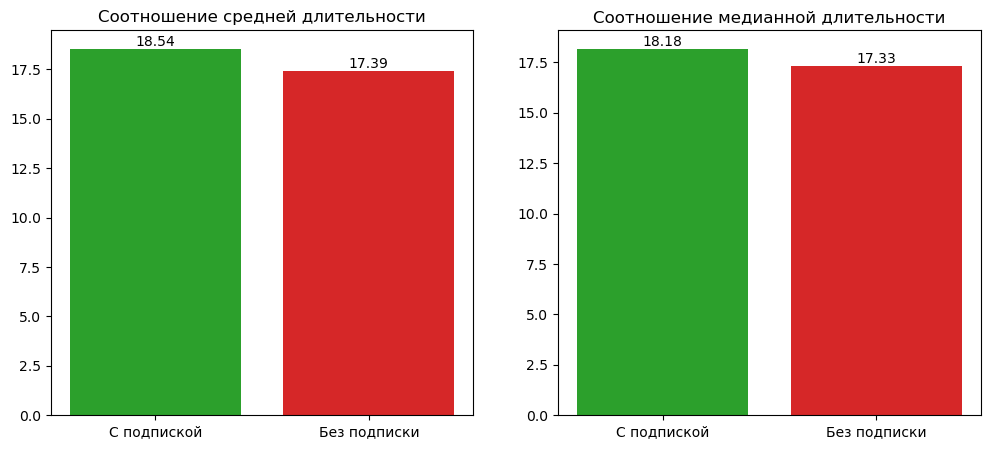

In [49]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars = ax1.bar(['С подпиской', 'Без подписки'],
        [_table_s['mean'], _table_ws['mean']],
        color=['tab:green', 'tab:red'])
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
ax1.set_title('Соотношение средней длительности')


bars = ax2.bar(['С подпиской', 'Без подписки'],
        [_table_s['median'], _table_ws['median']],
        color=['tab:green', 'tab:red'])
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
ax2.set_title('Соотношение медианной длительности');

---

In [50]:
_table_s = df_s['distance'].agg(['mean', 'median'])
_table_ws = df_ws['distance'].agg(['mean', 'median'])

In [51]:
_table_s

mean      3115.445388
median    3148.637229
Name: distance, dtype: float64

In [52]:
_table_ws

mean      3045.495282
median    3114.648465
Name: distance, dtype: float64

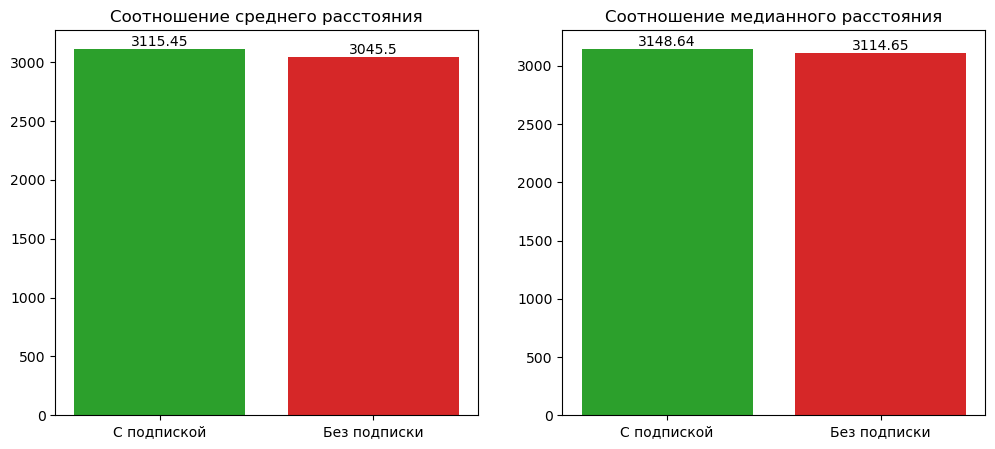

In [53]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars = ax1.bar(['С подпиской', 'Без подписки'],
        [_table_s['mean'], _table_ws['mean']],
        color=['tab:green', 'tab:red'])
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
ax1.set_title('Соотношение среднего расстояния')


bars = ax2.bar(['С подпиской', 'Без подписки'],
        [_table_s['median'], _table_ws['median']],
        color=['tab:green', 'tab:red'])
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
ax2.set_title('Соотношение медианного расстояния');

### 4.3. <a id='toc4_3_'></a>Вывод по объединению данных      [&#8593;](#toc0_)

Все 3 исходных датафрейма была объединены в один. Далее на основе были сформированы еще 2 датафрейма:
- `df_s` - информация о поездках пользователей С подпиской
- `df_ws` - информация о поездках пользователей БЕЗ подписки

У пользователей с подпиской и без нет кардинальных различий в длительности и расстоянии поездок. Медианная длительности у пользователей с подпиской больше на `1` минуту. Также расстояние у них чуть больше - на `4 метра`. Однако, учитывая, что медиана равна `3.1 км`, такую разницу можно объяснить статистической погрешностью.

## 5. <a id='toc5_'></a>Подсчет выручки      [&#8593;](#toc0_)

In [54]:
df['duration'] = np.ceil(df['duration'])

In [55]:
income = df.groupby(['user_id', 'month']).agg({
    'distance': ['sum', 'count'],
    'duration': 'sum'
})
income.columns = ['total_distance', 'rides_count', 'total_duration']
income = pd.merge(
    left=income,
    right=df
        .groupby('user_id')[['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
        .agg('first'),
    left_index=True,
    right_index=True)   

In [56]:
income.head(10)

total_distance  rides_count  total_duration subscription_type  \
user_id month                                                                  
1       1         7027.511294            2            42.0             ultra   
        4          754.159807            1             7.0             ultra   
        8         6723.470560            2            46.0             ultra   
        10        5809.911100            2            32.0             ultra   
        11        7003.499363            3            56.0             ultra   
        12        6751.629942            2            28.0             ultra   
2       3        10187.723006            3            63.0             ultra   
        4         6164.381824            2            40.0             ultra   
        6         3255.338202            1            14.0             ultra   
        7         6780.722964            2            48.0             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
        12                6                 0               199  
2       3                 6                 0               199  
        4                 6                 0               199  
        6                 6                 0               199  
        7                 6                 0               199

In [57]:
def calculate_total_price_for_ride(s: pd.Series) -> float:
    return s['start_ride_price'] * s['rides_count'] + s['minute_price'] * s['total_duration'] + s['subscription_fee']

In [58]:
income['total'] = income.apply(calculate_total_price_for_ride, axis=1)

In [59]:
income.head(10)

total_distance  rides_count  total_duration subscription_type  \
user_id month                                                                  
1       1         7027.511294            2            42.0             ultra   
        4          754.159807            1             7.0             ultra   
        8         6723.470560            2            46.0             ultra   
        10        5809.911100            2            32.0             ultra   
        11        7003.499363            3            56.0             ultra   
        12        6751.629942            2            28.0             ultra   
2       3        10187.723006            3            63.0             ultra   
        4         6164.381824            2            40.0             ultra   
        6         3255.338202            1            14.0             ultra   
        7         6780.722964            2            48.0             ultra   

               minute_price  start_ride_price  subscription_fee  total  
user_id month                                                           
1       1                 6                 0               199  451.0  
        4                 6                 0               199  241.0  
        8                 6                 0               199  475.0  
        10                6                 0               199  391.0  
        11                6                 0               199  535.0  
        12                6                 0               199  367.0  
2       3                 6                 0               199  577.0  
        4                 6                 0               199  439.0  
        6                 6                 0               199  283.0  
        7                 6                 0               199  487.0

### 5.1. <a id='toc5_1_'></a>Вывод  [&#8593;](#toc0_)

В данном разделе был сгенерирован новый датафрейм с информацией о пользователях по месяцам. В этот датафрейм был добавлен столбец с месячной выручкой.

## 6. <a id='toc6_'></a>Проверка гипотез      [&#8593;](#toc0_)

### 6.1. <a id='toc6_1_'></a>Продолжительность поездок      [&#8593;](#toc0_)

In [60]:
mean_s, median_s = df_s['duration'].agg(['mean', 'median'])

In [61]:
mean_ws, median_ws = df_ws['duration'].agg(['mean', 'median'])

In [62]:
table = PrettyTable()
table.field_names = ['', 'С подпиской', 'Без подписки']
table.add_row(['Средняя длительность',  round(mean_s, 2), round(mean_ws, 2)])
table.add_row(['Медианная длительность',  round(median_s, 2), round(median_ws, 2)])
print(table)

+------------------------+-------------+--------------+
|                        | С подпиской | Без подписки |
+------------------------+-------------+--------------+
|  Средняя длительность  |    18.54    |    17.39     |
| Медианная длительность |    18.18    |    17.33     |
+------------------------+-------------+--------------+


Сформулируем гипотезы:

$H_0$ - Средняя длительность пользователей с подпиской и без примерно равны  
$H_1$ - Средняя длительность пользователей с подпиской больше

In [63]:
alpha = 0.05

results = st.ttest_ind(
    df_s['duration'],
    df_ws['duration'],
    alternative='greater'
)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Нет причин отвергать H0')

p-value: 1.2804098316645618e-34
Отвергаем H0


**Вывод**

Можно сделать вывод, что продолжительность поездок у пользователей с подпиской больше, нежели у пользователей без подписки.

### 6.2. <a id='toc6_2_'></a>Среднее расстояние поездки      [&#8593;](#toc0_)

Сформулируем гипотезы:

$H_0$ - Среднее расстояние поездки примерно равно 3130м  
$H_1$ - Среднее расстояние поездки примерно больше 3130м

In [64]:
df_s['distance'].agg(['mean', 'median'])

mean      3115.445388
median    3148.637229
Name: distance, dtype: float64

In [65]:
results = st.ttest_1samp(df_s['distance'], 3130, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Нет причин отвергать H0')

p-value: 0.9195368847849785
Нет причин отвергать H0


**Вывод:**

Можно сдедать вывод, что среднее расстояние одной поездки для пользователей с подпиской примерно равно `3130` метров.

### 6.3. <a id='toc6_3_'></a>Сравнение помесячной выручки от пользователей с подпиской и без      [&#8593;](#toc0_)

In [66]:
income.head()

total_distance  rides_count  total_duration subscription_type  \
user_id month                                                                  
1       1         7027.511294            2            42.0             ultra   
        4          754.159807            1             7.0             ultra   
        8         6723.470560            2            46.0             ultra   
        10        5809.911100            2            32.0             ultra   
        11        7003.499363            3            56.0             ultra   

               minute_price  start_ride_price  subscription_fee  total  
user_id month                                                           
1       1                 6                 0               199  451.0  
        4                 6                 0               199  241.0  
        8                 6                 0               199  475.0  
        10                6                 0               199  391.0  
        11                6                 0               199  535.0

In [67]:
income['subscription_type'].value_counts()

subscription_type
free     6798
ultra    4533
Name: count, dtype: int64

In [68]:
_mask = income['subscription_type'] == 'free'
income_ws = income[_mask]
income_s = income[~_mask]

In [69]:
mean_s, median_s = income_s['total'].agg(['mean', 'median'])
mean_ws, median_ws = income_ws['total'].agg(['mean', 'median'])

table = PrettyTable()
table.field_names = ['', 'С подпиской', 'Без подписки']
table.add_row(['Средняя выручка',  round(mean_s, 2), round(mean_ws, 2)])
table.add_row(['Медианная выручка',  round(median_s, 2), round(median_ws, 2)])
print(table)

+-------------------+-------------+--------------+
|                   | С подпиской | Без подписки |
+-------------------+-------------+--------------+
|  Средняя выручка  |    362.79   |    328.64    |
| Медианная выручка |    337.0    |    274.0     |
+-------------------+-------------+--------------+


Сформулируем гипотезы:

$H_0$ - Средняя помесячная выручка от пользователей с подпиской и без примерно равны  
$H_1$ - Средняя помесячная выручка от пользователей с подписко больше

In [70]:
alpha = 0.05

results = st.ttest_ind(
    income_s['total'],
    income_ws['total'],
    alternative='greater'
)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Нет причин отвергать H0')

p-value: 1.8850394384715216e-31
Отвергаем H0


**Вывод**

В данном случае можно сделать вывод, что выручка от пользователей c подпиской выше, нежели от пользователей без подписки.

### 6.4. <a id='toc6_4_'></a>Ответ на вопрос      [&#8593;](#toc0_)

В данной ситуации нам подойдет тест о равенстве значения ГС ДО и ПОСЛЕ изменения. Он допустен как `scipy.stats.ttest_rel`. 

Сформулируем следующие гипотезы:  
$H_0$ - кол-во обращений ДО и ПОСЛЕ примерно одинаковое  
$H_1$ - кол-во обращений ПОСЛЕ снизилось, т.е. ДО было больше.

Можно воспользоваться таким кодом:

```python
from scipy import stats as st

alpha = 0.05
results = st.ttest_rel(
    before,
    after,
    alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Нет причин отвергнуть H0')
```

## 7. <a id='toc7_'></a>Общий вывод  [&#8593;](#toc0_)

В рамках данного исследования были проделаны следующие шаги:

1) **Загрузка и предобработка**  
Были загружены 3 различных датафрейма и обработаны: изменены типы данных, удалены полные дубликаты и проверены неявные дубликаты. Также был добавлен новый столбец с номером месяца.

2) **Исследовательский анализ данных**  
Были описаны и визуализированы следующие столбцы: города, тип подписки пользователей, возраст пользователей, расстояние 1 поездки и продолжительность поездок. Можно выделить следующие закономерности:
- **Города**  
    О каждом городе примерно одинаковое количество информации. Меньше всего информации о Москве (`168` пользователей), а больше всего о Пятигорске (`219` пользователей).

- **Наличие подписки**  
    Можно сделать вывод, что пользователей без подписки на `8 п.п.` больше, чем с подпиской.

- **Возраст**  
    Возраст пользователей имеет форму нормального распределения. Аномальных значений нет, а выбросы хоть и есть, но они являются вполне реальными значениями.  
    Минимальный возраст, о котором представлена информация - 12 лет, а максимальный - 43 года. Основная возрастная группа - от 16 до 34 лет, а средний возраст составляет 25 лет.

- **Расстояние одной поездки**  
    Расстояние за 1 поездку также имеет форму нормального распределения. Однако есть небольшой пик в поездках до `1000 м.`  
    Самая короткая поездка меньше метра, а самая длинная - более 7 км, целых `7211м`. Основная часть поездок находится в диапозоне от `1310` метров до `5009` метров. При этом средняя поездка составляет около `3км`.


- **Продолжительность одной поездки**  
    Продолжительность поездок также имеет форму нормального распределения. Самая короткая поездка длилась всего полминуты, а самая длинная почти `41` минуту. БОльшая часть поездок имеет длительность от `5.5` до `30` минут. При этом средняя длительность поездки - около `18` минут.

3) **Объединение датафреймов**  
Все 3 исходных датафрейма были объединены в один. Далее он был поделен на 2 различных: пользователей с подпиской и без нее.

4) **Подсчет выручки**  
Был сделал датафрейм с помесячной выручкой.

5) **Проверка гипотез**  
Были проверены 3 гипотезы. Результаты такие:  
    ✅ Продолжительность поездок у пользователей с подпиской больше, нежели у пользователей без подписки: `18.18`    против `17.33`  
    ✅ Среднее расстояние одной поездки для пользователей с подпиской примерно равно `3130` метров.  
    ✅ Выручка от пользователей c подпиской выше, нежели от пользователей без подписки: `337.0` против `274.0`.
    
В результате исследования можно сделать вывод о том, что пользователи с подпиской более выгодные для бизнеса.